In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
cd /notebooks/for_github

/notebooks/for_github


In [3]:
#Import plasma metabolomics data 
metabolomics=pd.read_csv('metabolomics_not_imputed.csv')
metabolomics.set_index('public_client_id',inplace=True)
metabolomics.shape
#load metabolomics metadata where additional biochemical information on each metabolite is stored
metabolomics_metadata=pd.read_csv('metabolomics_metadata.csv')

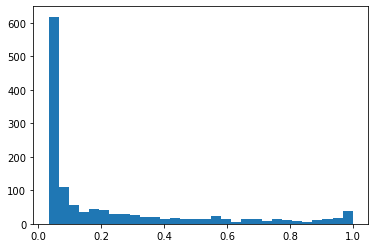

In [4]:
#what is the distribution of missing values across columns
missing=[x/len(metabolomics) for x in metabolomics.isnull().sum().tolist()]
plt.hist(missing,bins=30);

In [5]:
#Filter out columns with more than 10% missing values, common threshold in metabolomics research
mets_to_keep=[x for x in metabolomics.columns if metabolomics[x].isnull().sum()<=(0.1*len(metabolomics))]
clean_df=metabolomics[mets_to_keep]
clean_df.shape

(2026, 734)

In [6]:
#Along with imputing missing values in the metabolomics data,
#let's also check how the imputation algorithm actually performs on test set data

In [7]:
#scale/standardize variables
scaler = StandardScaler()
met_knn = pd.DataFrame(scaler.fit_transform(clean_df), columns = clean_df.columns,index=clean_df.index)

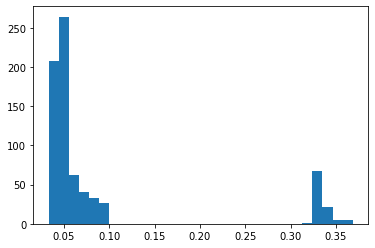

In [8]:
#define KNN imputatioin parameters
imputer=KNNImputer(n_neighbors=20,weights='distance')
test_df=clean_df.copy()
#sample 100 random metabolites from the dataframe
mets=test_df.columns.tolist()
random.seed(123)
random_test_mets = random.sample(mets, 100)
#convert 30% of each sampled metabolite column to NaN 
for x in random_test_mets:
    test_df[x] = test_df[x].sample(frac=0.7)
#let's see how it worked: 
missing=[x/len(test_df) for x in test_df.isnull().sum().tolist()]
#there is some extra missingness for each metabolite origiinally present in the data, contributing to
#the variability, that's ok,we can dealwith in the next step where we only subset rows that were originally not missing
plt.hist(missing,bins=30);

In [9]:
#perform imputation on data where we replaced 30% of known values across 100 mets with NaN
test_impute=pd.DataFrame(data=imputer.fit_transform(test_df),columns=test_df.columns,index=test_df.index)

In [10]:
#assess how well the algorithm imputed metabolites by comparinig imputed values to known observed values
name=[]
rho=[]
for x in random_test_mets:
    d=clean_df[clean_df[x].isnull()==False]
    d['imputed']=test_impute[x]
    corr=scipy.stats.spearmanr(d[x],d['imputed'])
    rho.append(corr[0])
test_results=pd.DataFrame()
test_results['met']=random_test_mets
test_results['correlations']=rho
#metabolites can be classified into broad groups of compounds with common biochemical properties
#like Lipid, Amino Acid, etc.
#Let's see if there are difference in how well the KNN imputer performs based on
#the biochemical class of the compound. We will get the metabolite class from the metadata file
new_names = []
for x in test_results['met']:
  new_names.append(metabolomics_metadata[metabolomics_metadata.BIOCHEMICAL_NAME == x].SUPER_PATHWAY.values[0])
test_results['pathway']=new_names
#let's see if the df looks correct
test_results.head()

,met,correlations,pathway
0,phenylalanine,0.830459,Amino Acid
1,1-dihomo-linoleoyl-GPC (20:2)*,0.879922,Lipid
2,pentadecanoate (15:0),0.876903,Lipid
3,"sphingomyelin (d18:1/24:1, d18:2/24:0)*",0.840146,Lipid
4,1-arachidonoyl-GPC (20:4n6)*,0.859470,Lipid


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


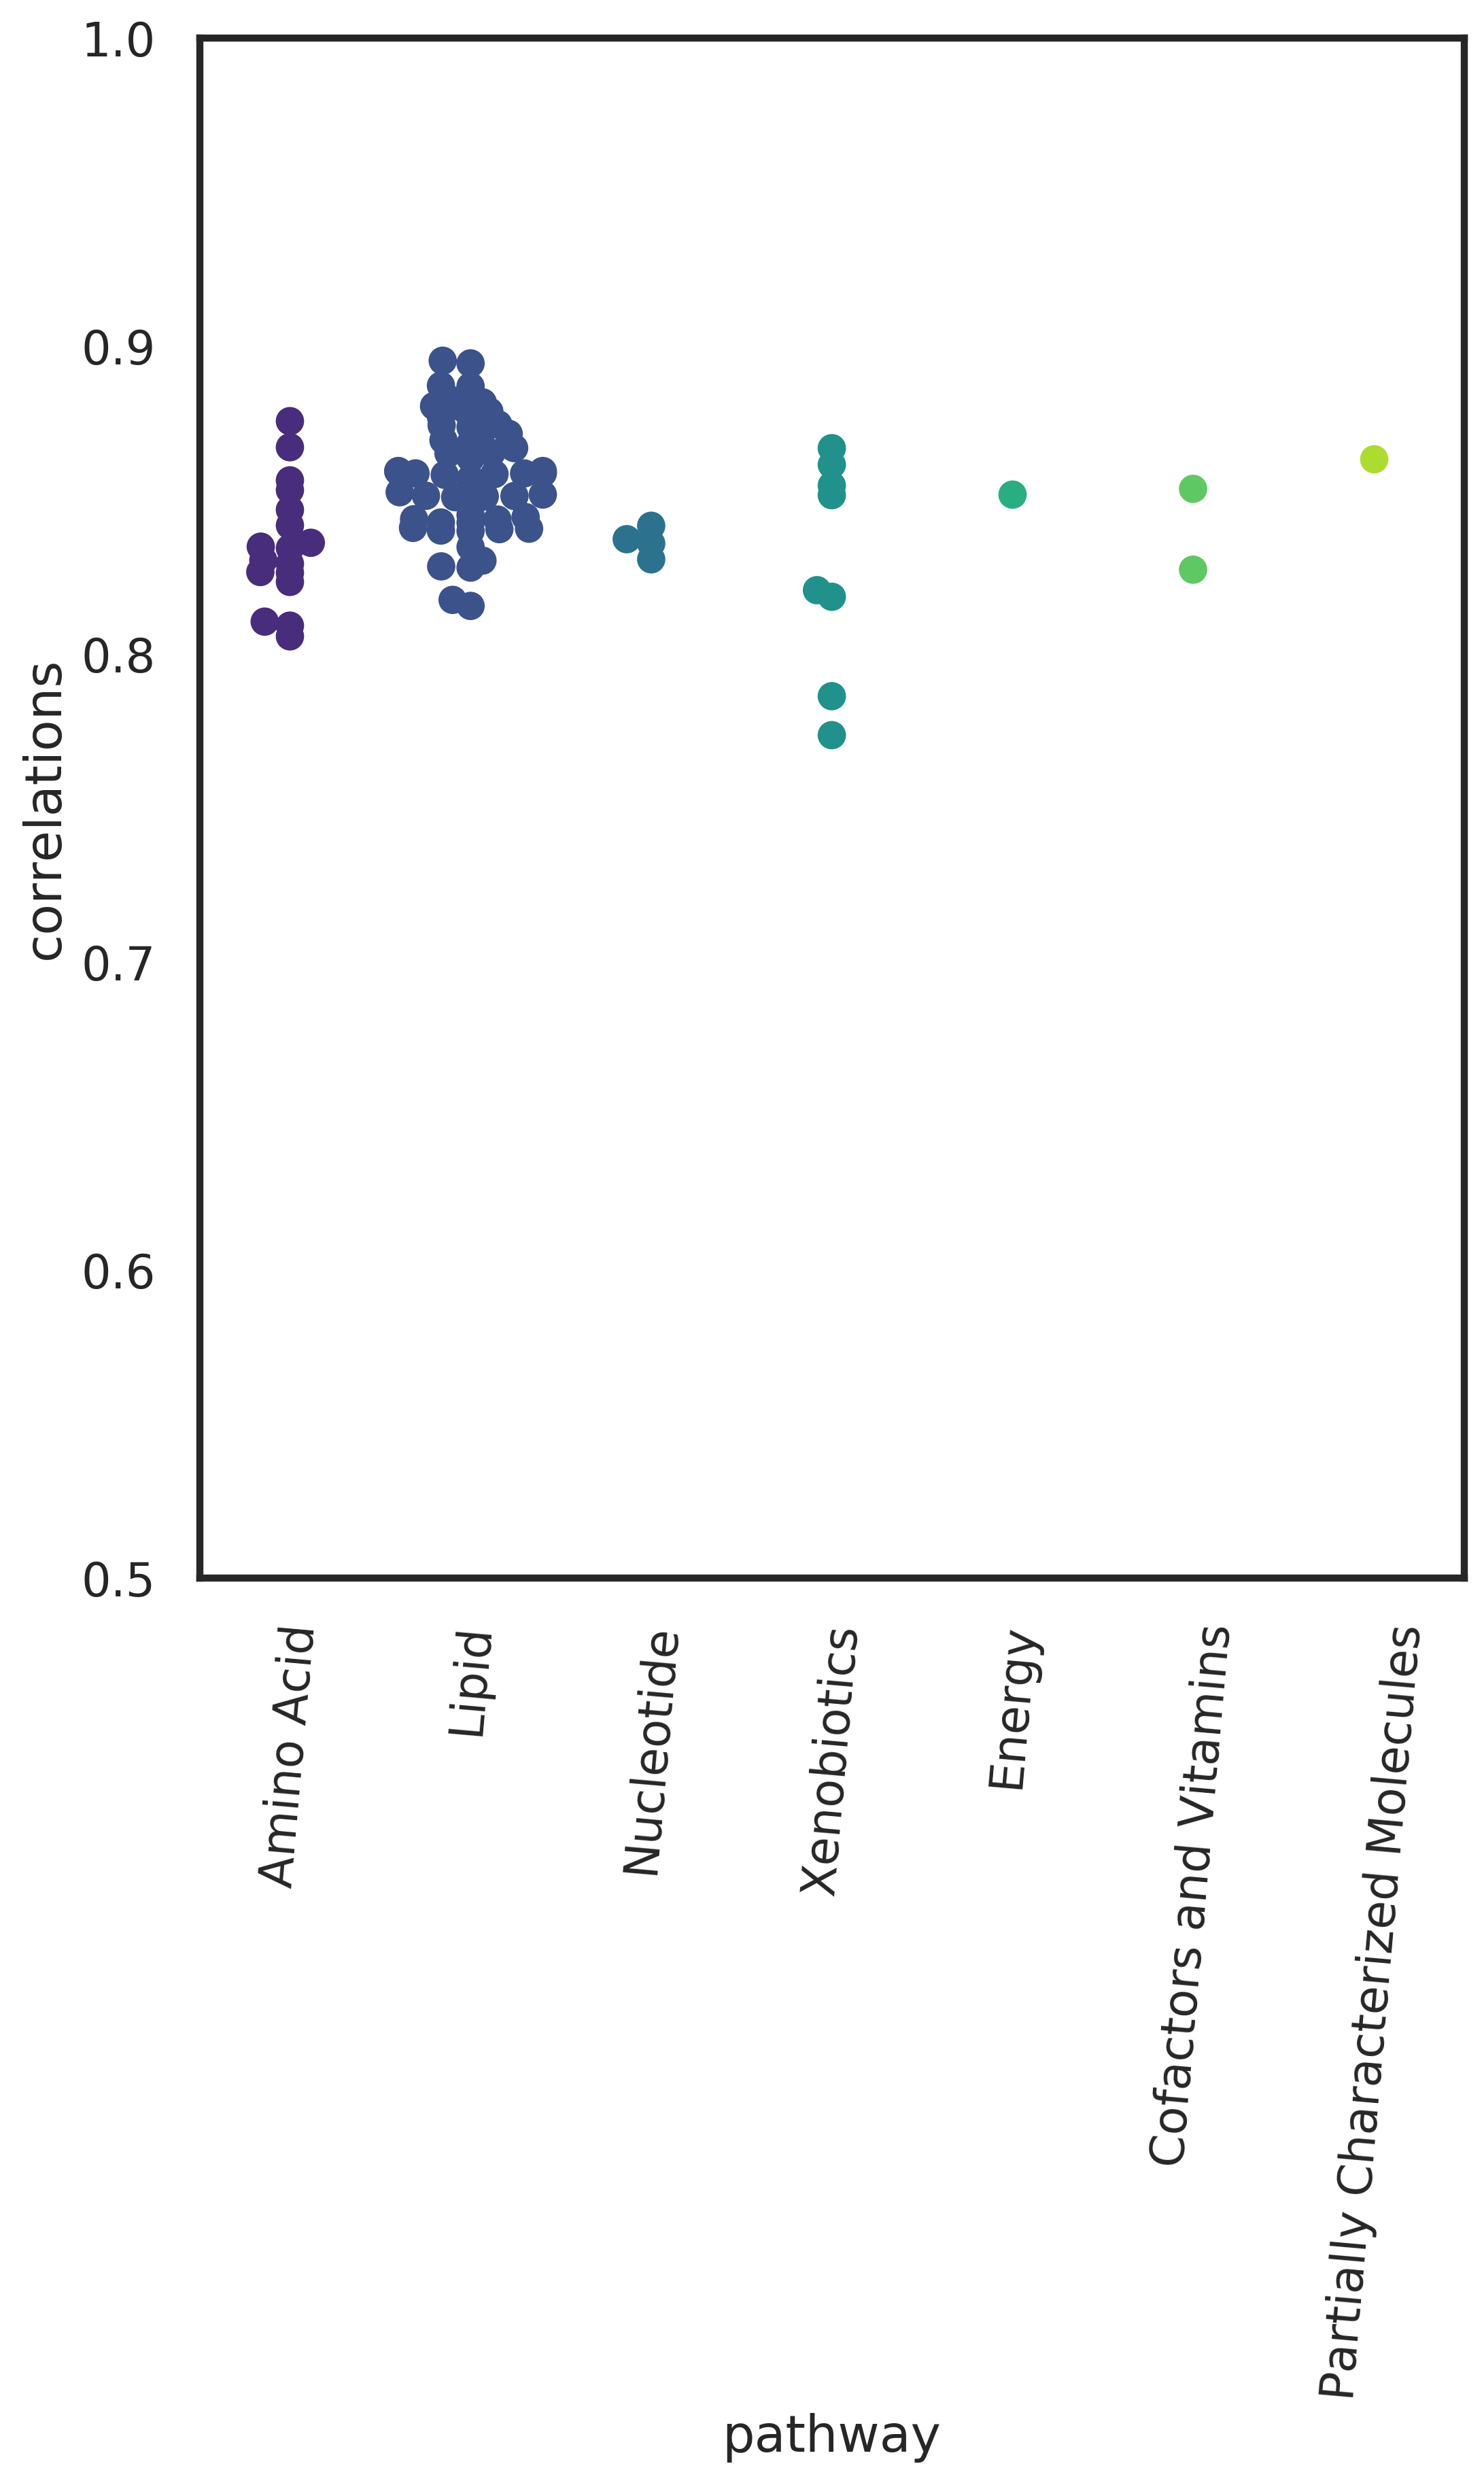

In [11]:
#let's see how the results look like across metabolite classes
sns.set(font_scale=0.75,context='poster',font='Arial',style='white')
plt.figure(figsize = (8,10),dpi=300)
ax = sns.swarmplot(x="pathway", y="correlations",size=10, data=test_results,palette="viridis",edgecolor='k')
ax.set_ylim(0.5,1.0)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 85);

In [12]:
#Doesn't look like any metabolite biochemical class is imputed drastically worse than others. Could the 
#imputation be improved with different KNN parameters? Let's check

In [13]:
test_results=pd.DataFrame()
for i in [5,10,20,50,100,200]:
    imputer=KNNImputer(n_neighbors=i,weights='distance')
    test_impute=pd.DataFrame(data=imputer.fit_transform(test_df),columns=test_df.columns,index=test_df.index)
    name=[]
    rho=[]
    for x in random_test_mets:
        d=clean_df[clean_df[x].isnull()==False]
        d['imputed']=test_impute[x]
        corr=scipy.stats.spearmanr(d[x],d['imputed'])
        rho.append(corr[0])
    test_results['met']=random_test_mets
    test_results['correlations_n='+str(i)]=rho
    print('finished n_neighbors={}'.format(i))

finished n_neighbors=5
finished n_neighbors=10
finished n_neighbors=20
finished n_neighbors=50
finished n_neighbors=100
finished n_neighbors=200


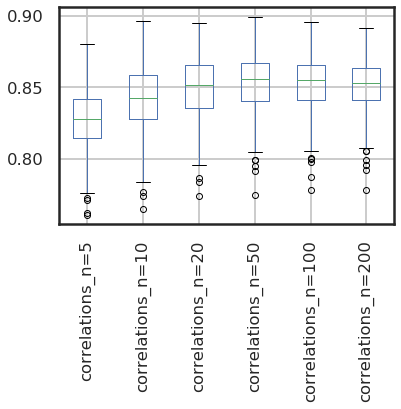

In [14]:
new_names = []
for x in test_results['met']:
  new_names.append(metabolomics_metadata[metabolomics_metadata.BIOCHEMICAL_NAME == x].SUPER_PATHWAY.values[0])
test_results['pathway']=new_names
test_results.boxplot()
plt.xticks(rotation=90);

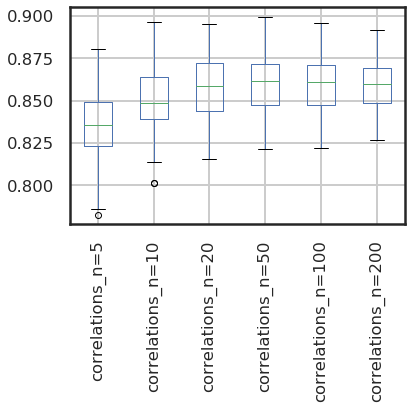

In [15]:
#looks like maybe up to 50 neighbors there is improvement in imputation, beyond which the curve plateaus
#what about specific lipid classes?
test_results[test_results['pathway']=='Lipid'].boxplot()
plt.xticks(rotation=90);

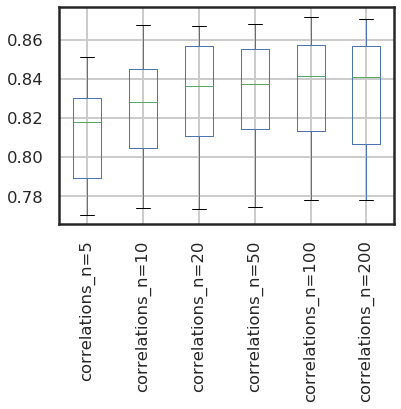

In [16]:
test_results[test_results['pathway']=='Xenobiotics'].boxplot()
plt.xticks(rotation=90);

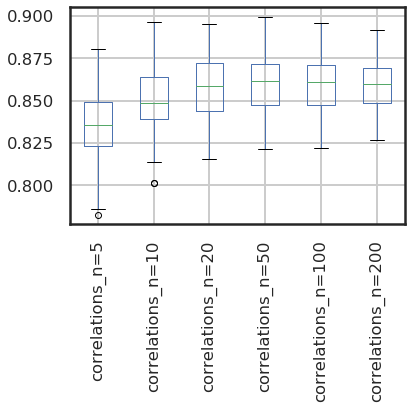

In [17]:
test_results[test_results['pathway']=='Lipid'].boxplot()
plt.xticks(rotation=90);

In [18]:
#let's finally impute our dataframe with the chosen n_neighbors= and save the new file as a CSV
imputer=KNNImputer(n_neighbors=50,weights='distance')
#impute missing values
impute_df=pd.DataFrame(data=imputer.fit_transform(met_knn),columns=met_knn.columns,index=met_knn.index)
impute_df.to_csv('metabolomics_imputed.csv')